In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import math, os

from cmaes import CMA

import jax
from jax import jit
import jax.numpy as jnp
from jax_metrics.losses import mean_absolute_error as jaxmae

## Load Dataset

In [15]:
df = pd.read_pickle('TrainDataSet.pkl')
df.drop(df[df.Surface == '111'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df

,Name,Surface,Type,Distance,Dist_Pd-C,Dist_Pd-O,DFT
0,100_h_1.75,100,h,1.75,"[9.969955369705993, 10.6812720583131, 10.05359...","[11.088097059458754, 11.731243268377185, 11.17...",-1.427916
1,100_b_1.36,100,b,1.36,"[9.92120608736274, 10.290457324167862, 9.82008...","[11.022061694073287, 11.354972553529421, 10.93...",-0.774615
2,100_b_2.57,100,b,2.57,"[11.044486058468518, 11.376728647929585, 10.96...","[12.12531769269826, 12.428170761469387, 12.057...",-0.239996
3,100_b_1.94,100,b,1.94,"[10.457223529520867, 10.80786950302053, 10.365...","[11.541101149677788, 11.859182995555319, 11.46...",-1.033478
4,100_t_2.47,100,t,2.47,"[10.910546850286872, 10.913436826251672, 10.65...","[11.99400745053601, 11.996086898004089, 11.768...",-0.480483
...,...,...,...,...,...,...,...
1078,PdCO9_9140,<NA>,<NA>,<NA>,"[4.075237237339686, 8.839570474819464, 4.42181...","[4.947631816940303, 9.950816969580941, 5.47033...",-1.820894
1079,PdCO9_3620,<NA>,<NA>,<NA>,"[4.327959832577006, 9.138317893759222, 4.16785...","[5.302690656393223, 10.20249343897853, 5.20934...",-1.750445
1080,PdCO9_6980,<NA>,<NA>,<NA>,"[3.802705916712467, 9.069004920089084, 4.29189...","[4.648030888935658, 10.205602026147208, 5.3438...",-1.852445
1081,PdCO9_2180,<NA>,<NA>,<NA>,"[4.0133658082586985, 9.670317856213416, 3.8749...","[5.006176531585757, 10.629603205900962, 4.8421...",-1.768625


## Visualize Dataset

Text(0, 0.5, 'Energy, eV')

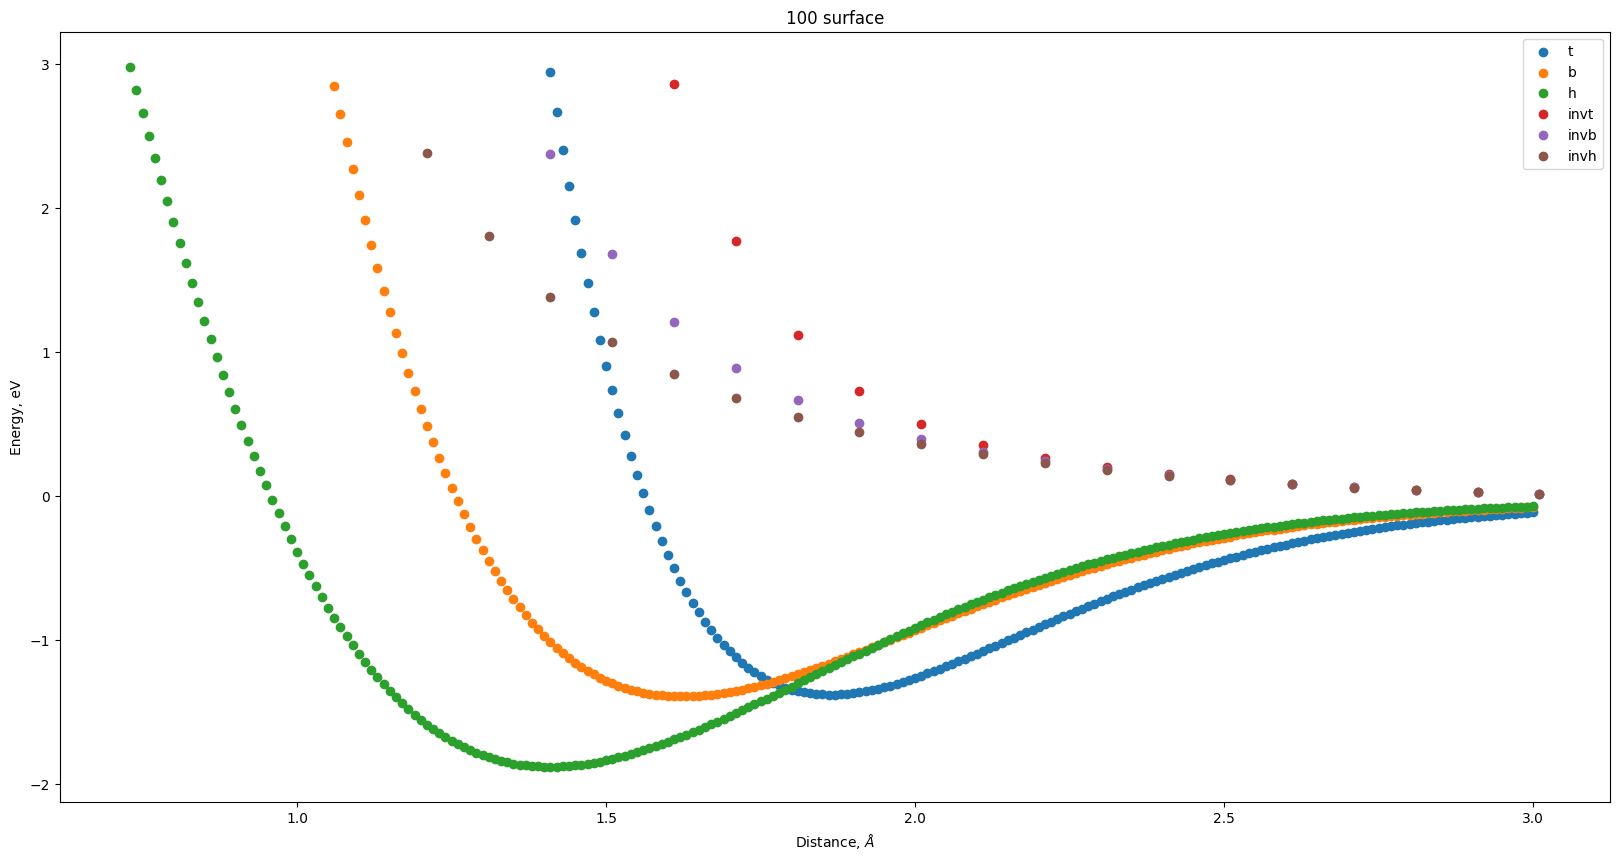

In [17]:
_categories = ['t', 'b', 'h', 'invt', 'invb', 'invh']
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
for pos in _categories:
    ax.scatter(df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Distance'],  df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['DFT'], label=pos)
ax.legend()
ax.title.set_text('100 surface')
ax.set_xlabel(r'Distance, $\AA$')
ax.set_ylabel('Energy, eV')

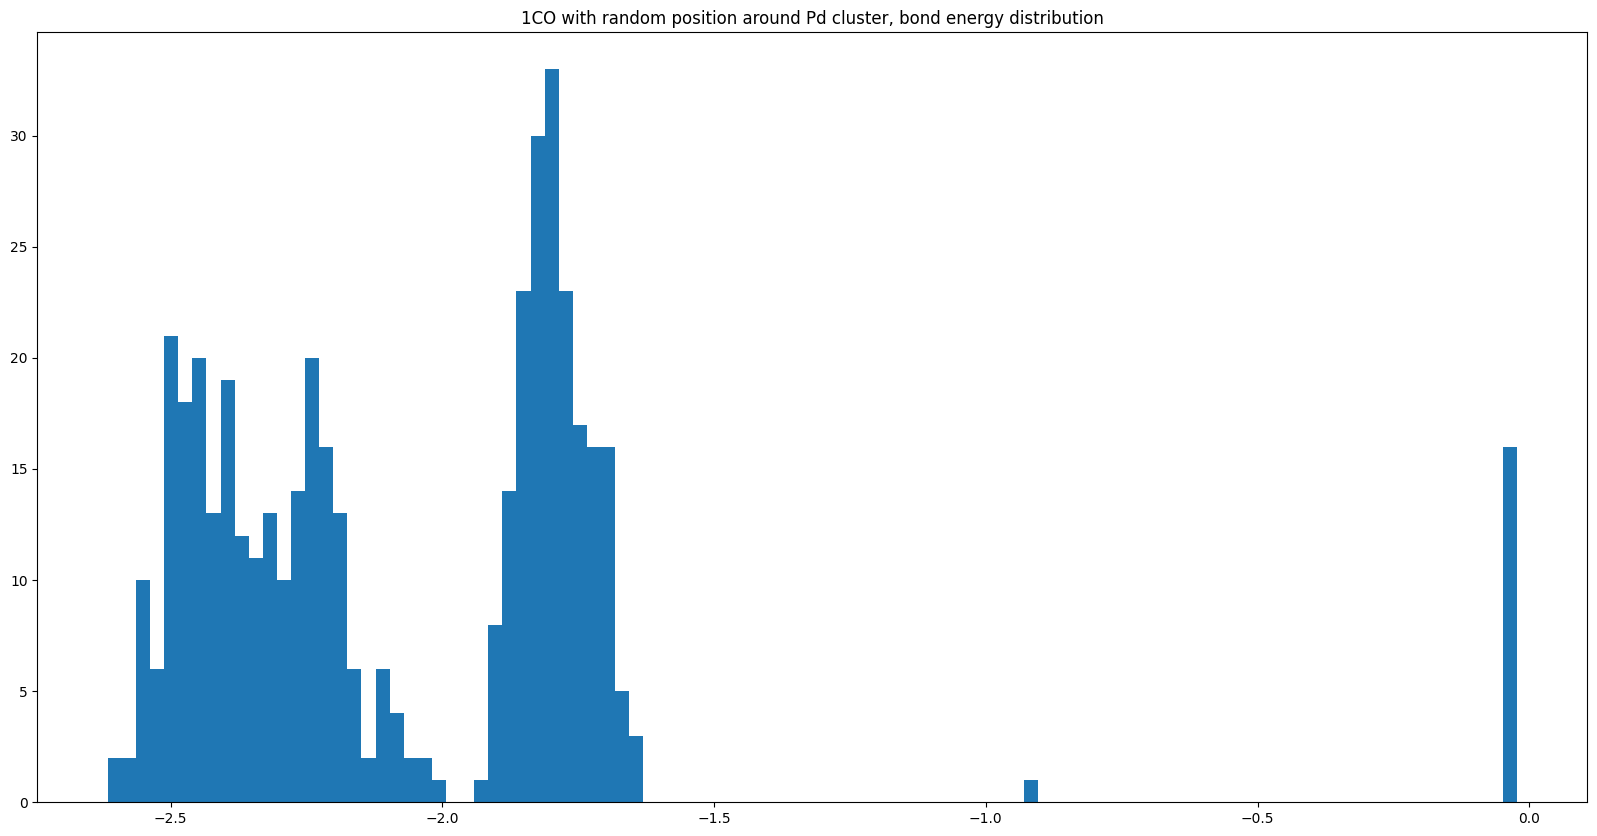

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.hist(df.loc[df['Distance'].isna()]['DFT'], bins = 100)
ax.title.set_text('1CO with random position around Pd cluster, bond energy distribution')

## Set potential cutoff

In [19]:
maxDist = 5.0 # cutoff for interactions
maxDistO = 5.0

In [20]:
nf = pd.DataFrame(columns=['ClipDist_Pd-C'], index=range(len(df)))
nfnf = pd.DataFrame(columns=['ClipDist_Pd-O'], index=range(len(df)))
for index, row in df.iterrows():
    distPdC = np.array(df['Dist_Pd-C'][index])
    clipped_row_PdC = distPdC[distPdC <= maxDist]
    
    distPdO = np.array(df['Dist_Pd-O'][index])
    clipped_row_PdO = distPdO[distPdO <= maxDistO]
    
    nf['ClipDist_Pd-C'][index] = clipped_row_PdC
    nfnf['ClipDist_Pd-O'][index] = clipped_row_PdO

df = pd.merge(
    df,
    nf,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN    
)

df = pd.merge(
    df,
    nfnf,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN
)

/tmp/ipykernel_9178/1654148918.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nf['ClipDist_Pd-C'][index] = clipped_row_PdC
/tmp/ipykernel_9178/1654148918.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0

In [21]:
df

,Name,Surface,Type,Distance,Dist_Pd-C,Dist_Pd-O,DFT,ClipDist_Pd-C,ClipDist_Pd-O
0,100_h_1.75,100,h,1.75,"[9.969955369705993, 10.6812720583131, 10.05359...","[11.088097059458754, 11.731243268377185, 11.17...",-1.427916,"[4.90846144314333, 4.878478570636844, 4.867039...","[4.319546197670725, 4.251906028206826, 3.29403..."
1,100_b_1.36,100,b,1.36,"[9.92120608736274, 10.290457324167862, 9.82008...","[11.022061694073287, 11.354972553529421, 10.93...",-0.774615,"[4.477359850770177, 4.035976687375164, 4.03998...","[4.699827629566639, 4.780219825397366, 3.38393..."
2,100_b_2.57,100,b,2.57,"[11.044486058468518, 11.376728647929585, 10.96...","[12.12531769269826, 12.428170761469387, 12.057...",-0.239996,"[4.723282464547583, 4.79397157399037, 3.402628...","[4.358747159168815, 4.364807222687448, 3.84104..."
3,100_b_1.94,100,b,1.94,"[10.457223529520867, 10.80786950302053, 10.365...","[11.541101149677788, 11.859182995555319, 11.46...",-1.033478,"[4.93611453071435, 4.538246494962151, 4.542490...","[3.8303115118059536, 3.836331179625224, 3.2460..."
4,100_t_2.47,100,t,2.47,"[10.910546850286872, 10.913436826251672, 10.65...","[11.99400745053601, 11.996086898004089, 11.768...",-0.480483,"[4.927517586808548, 4.920768496023526, 4.92484...","[4.583816947560896, 4.588543885892913, 3.61778..."
...,...,...,...,...,...,...,...,...,...
1078,PdCO9_9140,<NA>,<NA>,<NA>,"[4.075237237339686, 8.839570474819464, 4.42181...","[4.947631816940303, 9.950816969580941, 5.47033...",-1.820894,"[4.075237237339686, 4.421814471164524, 1.91305...","[4.947631816940303, 3.0648375054641988, 4.6027..."
1079,PdCO9_3620,<NA>,<NA>,<NA>,"[4.327959832577006, 9.138317893759222, 4.16785...","[5.302690656393223, 10.20249343897853, 5.20934...",-1.750445,"[4.327959832577006, 4.167857511839866, 1.87995...","[3.034596488118313, 4.735711356438439, 4.56609..."
1080,PdCO9_6980,<NA>,<NA>,<NA>,"[3.802705916712467, 9.069004920089084, 4.29189...","[4.648030888935658, 10.205602026147208, 5.3438...",-1.852445,"[3.802705916712467, 4.291894914533673, 1.89988...","[4.648030888935658, 3.0490171299945152, 4.4989..."
1081,PdCO9_2180,<NA>,<NA>,<NA>,"[4.0133658082586985, 9.670317856213416, 3.8749...","[5.006176531585757, 10.629603205900962, 4.8421...",-1.768625,"[4.0133658082586985, 3.8749892101656243, 1.879...","[4.842169465993524, 3.035526159103228, 4.99364..."


In [22]:
#calculate minimum Pd-C distance
minDistC = np.inf
for row in range(len(df['ClipDist_Pd-C'])):
    try:
        if min(np.atleast_1d(df['ClipDist_Pd-C'][row])) < minDistC:
            minDistC = min(np.atleast_1d(df['ClipDist_Pd-C'][row]))
    except Exception as error:
        print(error)
        print(row, df['ClipDist_Pd-C'][row], np.shape(df['ClipDist_Pd-C'][row]))
print(minDistC)

1.4099999999999113


In [23]:
#calculate minimum Pd-O distance
minDistO = np.inf
for row in range(len(df['ClipDist_Pd-O'])):
    try:
        if min(np.atleast_1d(df['ClipDist_Pd-O'][row])) < minDistO:
            minDistO = min(np.atleast_1d(df['ClipDist_Pd-O'][row]))
    except Exception as error:
        print(error)
        print(row, df['ClipDist_Pd-O'][row], np.shape(df['ClipDist_Pd-O'][row]))

print(minDistO)

min() arg is an empty sequence
644 [] (0,)
min() arg is an empty sequence
645 [] (0,)
min() arg is an empty sequence
652 [] (0,)
min() arg is an empty sequence
654 [] (0,)
min() arg is an empty sequence
662 [] (0,)
min() arg is an empty sequence
667 [] (0,)
min() arg is an empty sequence
676 [] (0,)
min() arg is an empty sequence
677 [] (0,)
min() arg is an empty sequence
680 [] (0,)
min() arg is an empty sequence
685 [] (0,)
min() arg is an empty sequence
687 [] (0,)
min() arg is an empty sequence
700 [] (0,)
min() arg is an empty sequence
703 [] (0,)
1.6099999999999426


## Balance dataset with weights

$$
WMAE = \frac{1}{\sum w_i} \sum\limits_{i=1}^n w_i|y_i - \hat{y_i}|
$$

In [24]:
Ninv= 0
for pos in ['invt', 'invb', 'invh']:
    Ninv += len(df.loc[df['Type'] == pos])

Nnormal = len(df)-Ninv
print('1st class: ', Ninv, '\n2nd class: ', Nnormal)

1st class:  51 
2nd class:  1032


In [25]:
try:
    df = df.drop('Weight', axis=1)
except:
    print('col not found')

col not found


In [26]:
df['Weight'] = 1.0

In [27]:
for pos in ['invt', 'invb', 'invh']:
   df['Weight'] = np.where(df['Type'] == pos, 1.2, df['Weight'])

df['Weight'] = np.where(df['DFT'] <-1.0, 1.5, df['Weight'])


wsum = np.sum(df['Weight'])
print(wsum)

1403.6999999999998


In [28]:
df

,Name,Surface,Type,Distance,Dist_Pd-C,Dist_Pd-O,DFT,ClipDist_Pd-C,ClipDist_Pd-O,Weight
0,100_h_1.75,100,h,1.75,"[9.969955369705993, 10.6812720583131, 10.05359...","[11.088097059458754, 11.731243268377185, 11.17...",-1.427916,"[4.90846144314333, 4.878478570636844, 4.867039...","[4.319546197670725, 4.251906028206826, 3.29403...",1.5
1,100_b_1.36,100,b,1.36,"[9.92120608736274, 10.290457324167862, 9.82008...","[11.022061694073287, 11.354972553529421, 10.93...",-0.774615,"[4.477359850770177, 4.035976687375164, 4.03998...","[4.699827629566639, 4.780219825397366, 3.38393...",1.0
2,100_b_2.57,100,b,2.57,"[11.044486058468518, 11.376728647929585, 10.96...","[12.12531769269826, 12.428170761469387, 12.057...",-0.239996,"[4.723282464547583, 4.79397157399037, 3.402628...","[4.358747159168815, 4.364807222687448, 3.84104...",1.0
3,100_b_1.94,100,b,1.94,"[10.457223529520867, 10.80786950302053, 10.365...","[11.541101149677788, 11.859182995555319, 11.46...",-1.033478,"[4.93611453071435, 4.538246494962151, 4.542490...","[3.8303115118059536, 3.836331179625224, 3.2460...",1.5
4,100_t_2.47,100,t,2.47,"[10.910546850286872, 10.913436826251672, 10.65...","[11.99400745053601, 11.996086898004089, 11.768...",-0.480483,"[4.927517586808548, 4.920768496023526, 4.92484...","[4.583816947560896, 4.588543885892913, 3.61778...",1.0
...,...,...,...,...,...,...,...,...,...,...
1078,PdCO9_9140,<NA>,<NA>,<NA>,"[4.075237237339686, 8.839570474819464, 4.42181...","[4.947631816940303, 9.950816969580941, 5.47033...",-1.820894,"[4.075237237339686, 4.421814471164524, 1.91305...","[4.947631816940303, 3.0648375054641988, 4.6027...",1.5
1079,PdCO9_3620,<NA>,<NA>,<NA>,"[4.327959832577006, 9.138317893759222, 4.16785...","[5.302690656393223, 10.20249343897853, 5.20934...",-1.750445,"[4.327959832577006, 4.167857511839866, 1.87995...","[3.034596488118313, 4.735711356438439, 4.56609...",1.5
1080,PdCO9_6980,<NA>,<NA>,<NA>,"[3.802705916712467, 9.069004920089084, 4.29189...","[4.648030888935658, 10.205602026147208, 5.3438...",-1.852445,"[3.802705916712467, 4.291894914533673, 1.89988...","[4.648030888935658, 3.0490171299945152, 4.4989...",1.5
1081,PdCO9_2180,<NA>,<NA>,<NA>,"[4.0133658082586985, 9.670317856213416, 3.8749...","[5.006176531585757, 10.629603205900962, 4.8421...",-1.768625,"[4.0133658082586985, 3.8749892101656243, 1.879...","[4.842169465993524, 3.035526159103228, 4.99364...",1.5


In [29]:
df.loc[df['Type'] == pos]

,Name,Surface,Type,Distance,Dist_Pd-C,Dist_Pd-O,DFT,ClipDist_Pd-C,ClipDist_Pd-O,Weight
55,100_invh_2.41,100,invh,2.41,"[11.707990418613573, 12.318515969909074, 11.79...","[10.60176641894211, 11.272951365383395, 10.685...",0.14089,"[4.801895061847701, 4.727592286792169, 3.88960...","[4.677609488400741, 4.6657236917053435, 3.9716...",1.2
59,100_invh_2.81,100,invh,2.81,"[12.092753565980042, 12.684593819641375, 12.17...","[10.986295474317334, 11.635122463055394, 11.06...",0.039002,"[4.264932892172329, 4.182313017895562]","[4.244202230754408, 4.177869982136708, 3.19771...",1.2
127,100_invh_2.51,100,invh,2.51,"[11.803881105157553, 12.409644100948363, 11.88...","[10.697792317277747, 11.363256269542525, 10.78...",0.107392,"[4.879625609126762, 4.804464285322453, 3.98282...","[4.773426552192441, 4.761478490105749, 4.03779...",1.2
145,100_invh_2.91,100,invh,2.91,"[12.189410748503612, 12.776729660017036, 12.27...","[11.082598860863284, 11.726049432408972, 11.16...",0.025212,"[4.35970810988116, 4.276713323154871]","[4.315445798285668, 4.247874552224877, 3.28881...",1.2
198,100_invh_2.61,100,invh,2.61,"[11.89995631977878, 12.501019075503319, 11.983...","[10.793890388798882, 11.453722259959667, 10.87...",0.079324,"[4.9582270694111115, 4.882245160677627, 4.0764...","[4.869411830229083, 4.8574043743689765, 4.1053...",1.2
214,100_invh_1.31,100,invh,1.31,"[10.687986083601098, 11.354029961785812, 10.77...","[9.550866417347024, 10.2914365525566, 9.634617...",1.80316,"[4.7636370975298234, 4.751695257004486, 4.0309...","[4.573926280213084, 4.541923420473091, 4.53063...",1.2
270,100_invh_2.71,100,invh,2.71,"[11.996300416071433, 12.59272006185925, 12.079...","[10.890058722853952, 11.544345549631565, 10.97...",0.057215,"[4.960970431362088, 4.170537837868585, 4.08831...","[4.965555567665725, 4.953491405114176, 4.17413...",1.2
285,100_invh_1.21,100,invh,1.21,"[10.600421733216411, 11.271687464548435, 10.68...","[9.45588388571925, 10.203406575957654, 9.53965...",2.383781,"[4.676268450301646, 4.664383547203021, 3.97072...","[4.500427630994983, 4.467941766478292, 4.45669...",1.2
365,100_invh_1.91,100,invh,1.91,"[11.234414908117897, 11.869562199943864, 11.31...","[10.12279135875105, 10.823984002265327, 10.206...",0.443918,"[4.429914650521303, 4.360509234648046, 3.43331...","[4.993364777430746, 4.201449501062119, 4.18992...",1.2
371,100_invh_1.51,100,invh,1.51,"[10.866836239112617, 11.522453833253815, 10.95...","[9.741132780411515, 10.468141546487544, 9.8248...",1.072245,"[4.942331342009384, 4.930280632408091, 4.15740...","[4.723844528223183, 4.692781458265688, 4.68141...",1.2


## Preparing arrays for optimizer

In [30]:
dft = jnp.asarray(df['DFT'].to_numpy(dtype='float64'))

C = df['ClipDist_Pd-C'].to_numpy()
O = df['ClipDist_Pd-O'].to_numpy()

Csizes = [len(np.atleast_1d(C[i])) for i in range(len(C))]
Cragged_arrays = [np.hstack((C[i], np.asarray([np.nan]*(55-Csizes[i])))) for i in range(len(Csizes))]

PdCsizes = jnp.asarray(Csizes)
PdCdistances = jnp.asarray(Cragged_arrays)

Osizes = [len(np.atleast_1d(O[i])) for i in range(len(O))]
Oragged_arrays = [np.hstack((O[i], np.asarray([np.nan]*(55-Osizes[i])))) for i in range(len(Osizes))]

PdOsizes = jnp.asarray(Osizes)
PdOdistances = jnp.asarray(Oragged_arrays)

weights = jnp.asarray(df['Weight'].to_numpy(dtype='float64'))

In [31]:
@jit
def LJpot(carry, x):
    array, end_idx = x
    par, _ = carry
    s = jax.lax.fori_loop(0, end_idx, lambda i, s: s + 4.0*par[0]*(jnp.power(par[1]/array[i], 12) - jnp.power(par[1]/array[i], 6) ), 0.)
    return  (par, _+s), s

@jit
def Exppot(carry, x):
    array, end_idx = x
    par, _ = carry
    s = jax.lax.fori_loop(0, end_idx, lambda i, s: s + par[0]*jnp.exp(-par[1]*array[i])*jnp.power(maxDistO - array[i], 2), 0.)
    return  (par, _+s), s

@jit
def Padepot(carry, x):
    array, end_idx = x
    p, q, _ = carry
    s = jax.lax.fori_loop(0, end_idx, lambda i, s: s + jnp.power(maxDist - array[i], 2)*jnp.polyval(p, array[i])/jnp.polyval(q, array[i]), 0.)
    return  (p, q, _+s), s

@jit
def get_mae(distances, sizes, distances2, sizes2, truth, PdCp, PdCq, PdO, weight):
    _, potC = jax.lax.scan(Padepot, (PdCp, PdCq, 0.), (distances, sizes)) 
    _, potO = jax.lax.scan(Exppot, (PdO, 0.), (distances2, sizes2)) 
    return jaxmae(potC+potO, dft)
    #return jnp.average(weight*jnp.abs(potC + potO - truth))/wsum

@jit
def get_predictedE(distances, sizes, distances2, sizes2, params, PdCp, PdCq, PdO):
    _, potC = jax.lax.scan(Padepot, (PdCp, PdCq, 0.), (distances, sizes))
    _, potO = jax.lax.scan(Exppot, (PdO, 0.), (distances2, sizes2))
    return potC+potO

MAE = jit(get_mae)
MAE(PdCdistances, PdCsizes, PdOdistances, PdOsizes, dft, jnp.array([0., 1., 2.]), jnp.array([0., 1., 2.]), jnp.array([1., 1.]), weights)

Array(23.304138, dtype=float32)

In [32]:
%timeit MAE(PdCdistances, PdCsizes, PdOdistances, PdOsizes, dft, jnp.array([0., 1., 2.]), jnp.array([0., 1., 2.]), jnp.array([1., 2.]), weights).block_until_ready()

3.01 ms ± 75.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Fitting

In [33]:
def CMA1(mean, sigma, bounds, m1, n1):
    optimizer = CMA(mean = mean, sigma = sigma, bounds = bounds )

    best_value = np.inf
    
    for generation in range(10000):
        solutions = []
        
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            #print(x[:m1], np.hstack((1., x[m1:m1+n1])), x[m1+n1:])
            value = MAE(PdCdistances, PdCsizes, PdOdistances, PdOsizes, dft, jnp.array(x[:m1]), jnp.array(np.hstack((1., x[m1:m1+n1]))), jnp.array(x[m1+n1:]), weights)
            if value<best_value:
                best_value = value
                best_parameters = x
                #print(f"#{generation} {value} {best_parameters}")
            solutions.append((x, value))
        optimizer.tell(solutions)

        
        if optimizer.should_stop():
            print('Devochka, stop! Ne nado.')
            break

        if (generation + 1) % 100 == 0: print(f"#{generation+1} {best_value} {best_parameters}")
        
    return best_value, best_parameters

In [34]:
m1, n1 = 4, 4
Npars = m1+n1+2
lb, ub = -100.0, 100.0

sigma = 5.0
#mean = np.concatenate([[1e-8]]*Npars, axis=0)
mean = np.hstack((np.random.uniform(low=-1, high=1, size=(Npars-2,)),  np.multiply(np.random.rand(2), np.array([5.0, 5.0]))))
print(mean)


print(np.concatenate([[[lb,ub]]]*(Npars-2), axis=0))
bounds = np.vstack( (np.concatenate([[[lb,ub]]]*(Npars-2), axis=0), [[1e-8, 10], [1e-8, 10.0]]) )
print(bounds)

best_value, best_parameters = CMA1(mean, sigma, bounds, m1, n1)

[ 0.34080007  0.3275742  -0.25226582  0.64173668  0.20163954 -0.0697117
  0.83357246  0.43712313  4.70040018  2.53790585]
[[-100.  100.]
 [-100.  100.]
 [-100.  100.]
 [-100.  100.]
 [-100.  100.]
 [-100.  100.]
 [-100.  100.]
 [-100.  100.]]
[[-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [-1.e+02  1.e+02]
 [ 1.e-08  1.e+01]
 [ 1.e-08  1.e+01]]
#100 0.4877326190471649 [ 1.61558488 -4.78422523 -7.15514873 11.08690966  4.53255211  6.6275933
  0.22130713 10.27847985  2.36077457  1.73758844]
#200 0.30830273032188416 [  1.41635576  -3.54621787 -11.27549771  21.69907375   4.13708687
  -0.29218806 -12.84760154  10.58973561   1.99176928   1.60327323]
#300 0.23359690606594086 [ -0.84715254   5.86587413 -14.08208973  11.09877931   1.46332955
  -7.96197583  -5.54249863  18.35970151   1.22772307   1.30417109]
#400 0.23240573704242706 [ -0.90276041   6.22365019 -14.81173162  11.58845324   1.65860397
  -8.65350812

In [35]:
print(best_value, best_parameters)

0.16532767 [ -0.69871957   5.37035503 -13.11545158  10.13122393 -11.00505846
  43.58221948 -71.41747127  42.56109039   0.90869173   1.09017918]


In [2]:
best_parameters =  [ -0.69912645,   5.37338359, -13.12257672,  10.13652903, -11.00468845,
  43.57962637, -71.41173479,  42.55790599,   0.90811168,  1.08987219]

In [31]:
"""
with open('LJLJ.txt', 'a') as f:
    f.write('#'*50+'\n\n')
    f.write('INPUT PARAMETERS\n\n')
    f.write(f'Initial sigma: {sigma}\n')
    f.write(f'Initial parameters: {mean}\n')
    f.write(f'Bounds: {bounds}\n\n')
    f.write('OUTPUT PARAMETERS\n\n')
    f.write(f'Error {best_value}\n')
    f.write(f'Parameters {best_parameters}\n\n')
    f.write('#'*50+'\n')
"""

"\nwith open('LJLJ.txt', 'a') as f:\n    f.write('#'*50+'\n\n')\n    f.write('INPUT PARAMETERS\n\n')\n    f.write(f'Initial sigma: {sigma}\n')\n    f.write(f'Initial parameters: {mean}\n')\n    f.write(f'Bounds: {bounds}\n\n')\n    f.write('OUTPUT PARAMETERS\n\n')\n    f.write(f'Error {best_value}\n')\n    f.write(f'Parameters {best_parameters}\n\n')\n    f.write('#'*50+'\n')\n"

[ -0.69871956   5.370355   -13.115452    10.131224  ] [  1.       -11.005058  43.58222  -71.41747   42.56109 ]


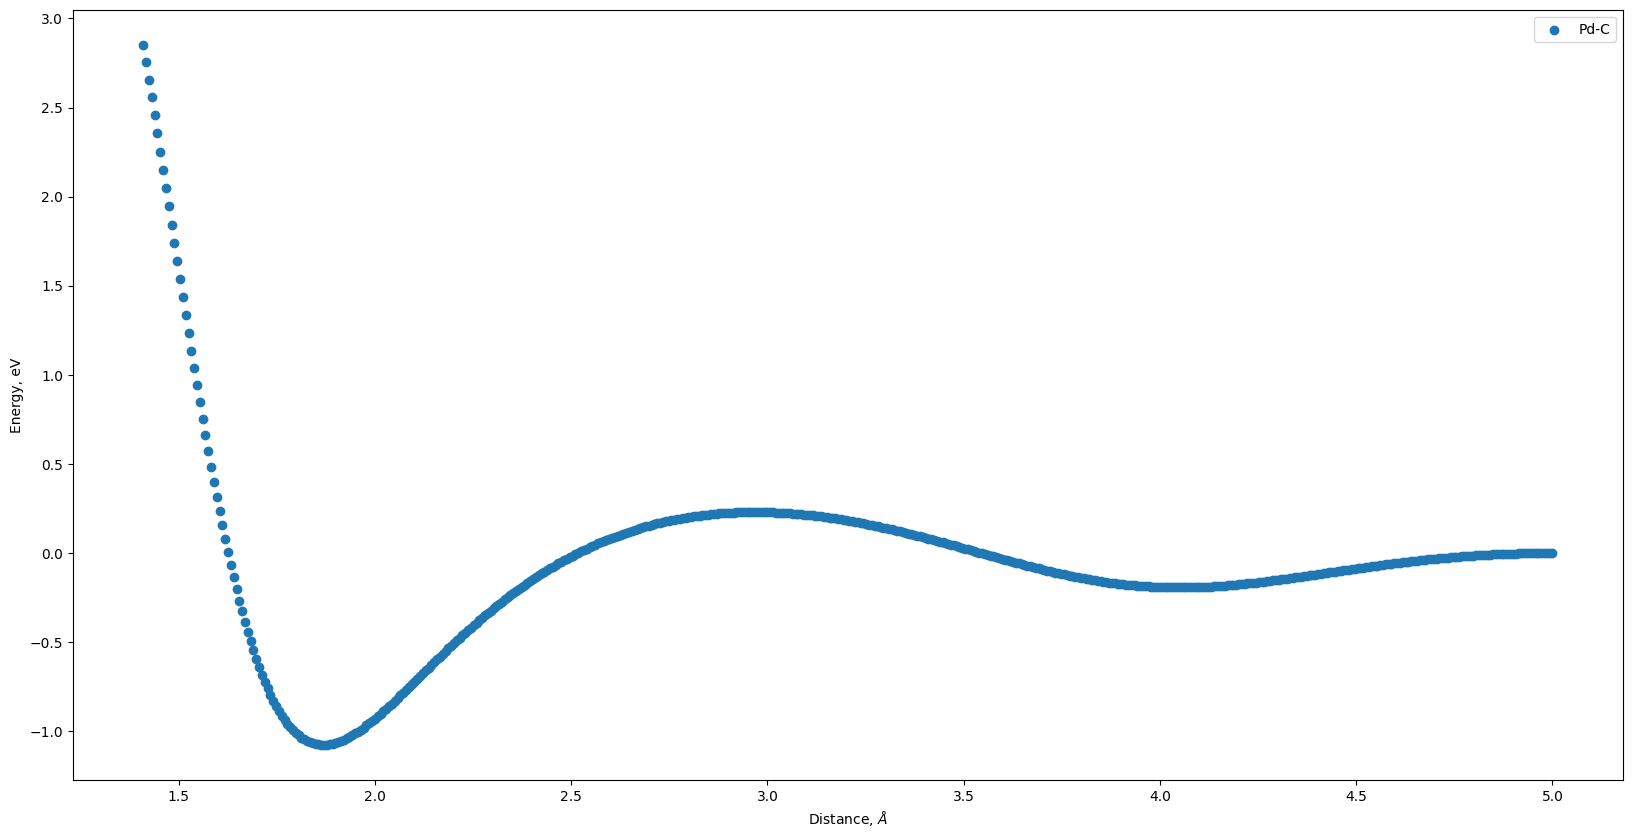

In [49]:
r = np.linspace(minDistC, maxDist, 500)

pp = jnp.array(best_parameters[:m1])
qq = jnp.array(np.hstack((1., best_parameters[m1:m1+n1])))
print(pp, qq)

PdCE = [jnp.power(maxDist - x, 2)*jnp.polyval(pp, x)/jnp.polyval(qq, x) for x in r]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.scatter(r, PdCE, label='Pd-C')
ax.set_xlabel('Distance, $\AA$')
ax.set_ylabel('Energy, eV')
ax.legend()

with open('PdC_pade.txt', 'w') as f:
    for rrr, eee in zip(r, PdCE):
        f.write(f'{rrr} {eee}\n')

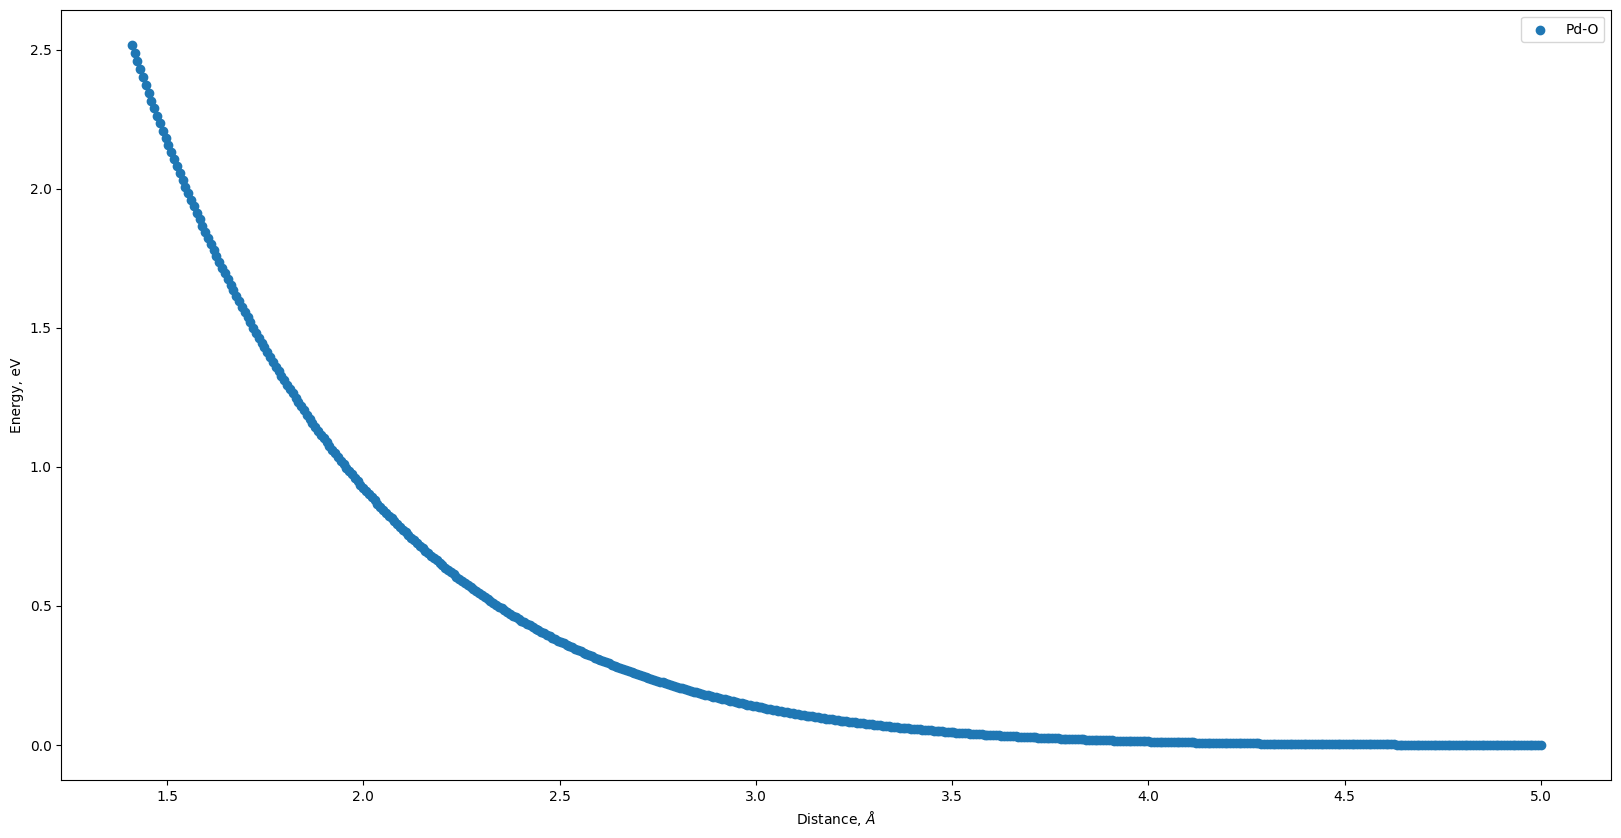

In [50]:
r = np.linspace(minDistC, maxDistO, 500)
PdOE = [best_parameters[-2]*jnp.exp(-best_parameters[-1]*x)*jnp.power(maxDistO - x, 2) for x in r]

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.scatter(r, PdOE, label='Pd-O')
ax.set_xlabel('Distance, $\AA$')
ax.set_ylabel('Energy, eV')
ax.legend()

with open('PdO_pade.txt', 'w') as f:
    for rrr, eee in zip(r, PdOE):
        f.write(f'{rrr} {eee}\n')

In [38]:
try:
    df = df.drop('Fit', axis=1)
except:
    print('col not found')
print(jnp.asarray(best_parameters))
df['Fit']=get_predictedE(PdCdistances, PdCsizes, PdOdistances, PdOsizes, dft, jnp.array(best_parameters[:m1]), jnp.array(np.hstack((1., best_parameters[m1:m1+n1]))), jnp.array(best_parameters[m1+n1:]))

col not found
[ -0.69871956   5.370355   -13.115452    10.131224   -11.005058
  43.58222    -71.41747     42.56109      0.9086917    1.0901792 ]


In [39]:
df

,Name,Surface,Type,Distance,Dist_Pd-C,Dist_Pd-O,DFT,ClipDist_Pd-C,ClipDist_Pd-O,Weight,Fit
0,100_h_1.75,100,h,1.75,"[9.969955369705993, 10.6812720583131, 10.05359...","[11.088097059458754, 11.731243268377185, 11.17...",-1.427916,"[4.90846144314333, 4.878478570636844, 4.867039...","[4.319546197670725, 4.251906028206826, 3.29403...",1.5,-1.176321
1,100_b_1.36,100,b,1.36,"[9.92120608736274, 10.290457324167862, 9.82008...","[11.022061694073287, 11.354972553529421, 10.93...",-0.774615,"[4.477359850770177, 4.035976687375164, 4.03998...","[4.699827629566639, 4.780219825397366, 3.38393...",1.0,-0.774619
2,100_b_2.57,100,b,2.57,"[11.044486058468518, 11.376728647929585, 10.96...","[12.12531769269826, 12.428170761469387, 12.057...",-0.239996,"[4.723282464547583, 4.79397157399037, 3.402628...","[4.358747159168815, 4.364807222687448, 3.84104...",1.0,-0.131517
3,100_b_1.94,100,b,1.94,"[10.457223529520867, 10.80786950302053, 10.365...","[11.541101149677788, 11.859182995555319, 11.46...",-1.033478,"[4.93611453071435, 4.538246494962151, 4.542490...","[3.8303115118059536, 3.836331179625224, 3.2460...",1.5,-0.915569
4,100_t_2.47,100,t,2.47,"[10.910546850286872, 10.913436826251672, 10.65...","[11.99400745053601, 11.996086898004089, 11.768...",-0.480483,"[4.927517586808548, 4.920768496023526, 4.92484...","[4.583816947560896, 4.588543885892913, 3.61778...",1.0,-0.636324
...,...,...,...,...,...,...,...,...,...,...,...
1078,PdCO9_9140,<NA>,<NA>,<NA>,"[4.075237237339686, 8.839570474819464, 4.42181...","[4.947631816940303, 9.950816969580941, 5.47033...",-1.820894,"[4.075237237339686, 4.421814471164524, 1.91305...","[4.947631816940303, 3.0648375054641988, 4.6027...",1.5,-1.765729
1079,PdCO9_3620,<NA>,<NA>,<NA>,"[4.327959832577006, 9.138317893759222, 4.16785...","[5.302690656393223, 10.20249343897853, 5.20934...",-1.750445,"[4.327959832577006, 4.167857511839866, 1.87995...","[3.034596488118313, 4.735711356438439, 4.56609...",1.5,-1.701055
1080,PdCO9_6980,<NA>,<NA>,<NA>,"[3.802705916712467, 9.069004920089084, 4.29189...","[4.648030888935658, 10.205602026147208, 5.3438...",-1.852445,"[3.802705916712467, 4.291894914533673, 1.89988...","[4.648030888935658, 3.0490171299945152, 4.4989...",1.5,-1.661337
1081,PdCO9_2180,<NA>,<NA>,<NA>,"[4.0133658082586985, 9.670317856213416, 3.8749...","[5.006176531585757, 10.629603205900962, 4.8421...",-1.768625,"[4.0133658082586985, 3.8749892101656243, 1.879...","[4.842169465993524, 3.035526159103228, 4.99364...",1.5,-1.760462


Text(0, 0.5, 'Energy, eV')

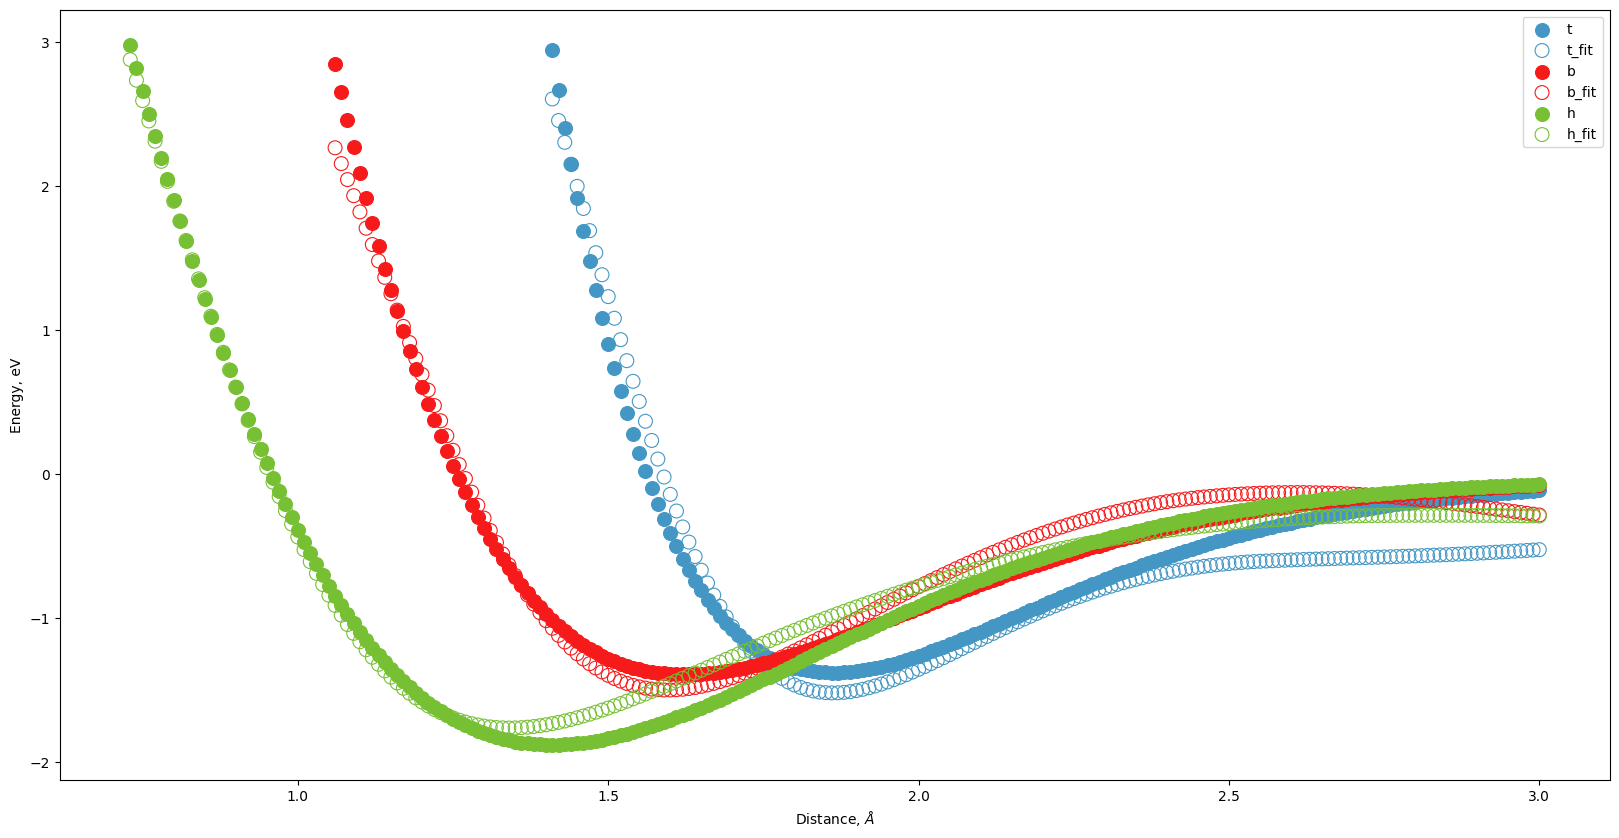

In [48]:
_categories = ['t', 'b', 'h']
colors = ['#4497c4', '#f71a1a', '#77c034']
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
i=0
for pos in _categories:
    XX=df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Distance']
    YY=df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['DFT']
    sns.scatterplot(x=XX,  y=YY, label=pos, edgecolor=colors[i], facecolor=colors[i], s=100)
    pd.concat([XX,YY], axis=1).to_csv(f'{pos}_dft.csv')
   
    XX = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Distance']
    YY = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Fit']
    sns.scatterplot(x=XX,  y=YY, label=pos+'_fit', edgecolor=colors[i], facecolor='none', s=100)
    pd.concat([XX,YY], axis=1).to_csv(f'{pos}_padeexp.csv')
    
    i+=1
    
#ax.set_ylim(-2.5,3)
ax.legend()
ax.set_xlabel(r'Distance, $\AA$')
ax.set_ylabel('Energy, eV')

Text(0, 0.5, 'Energy, eV')

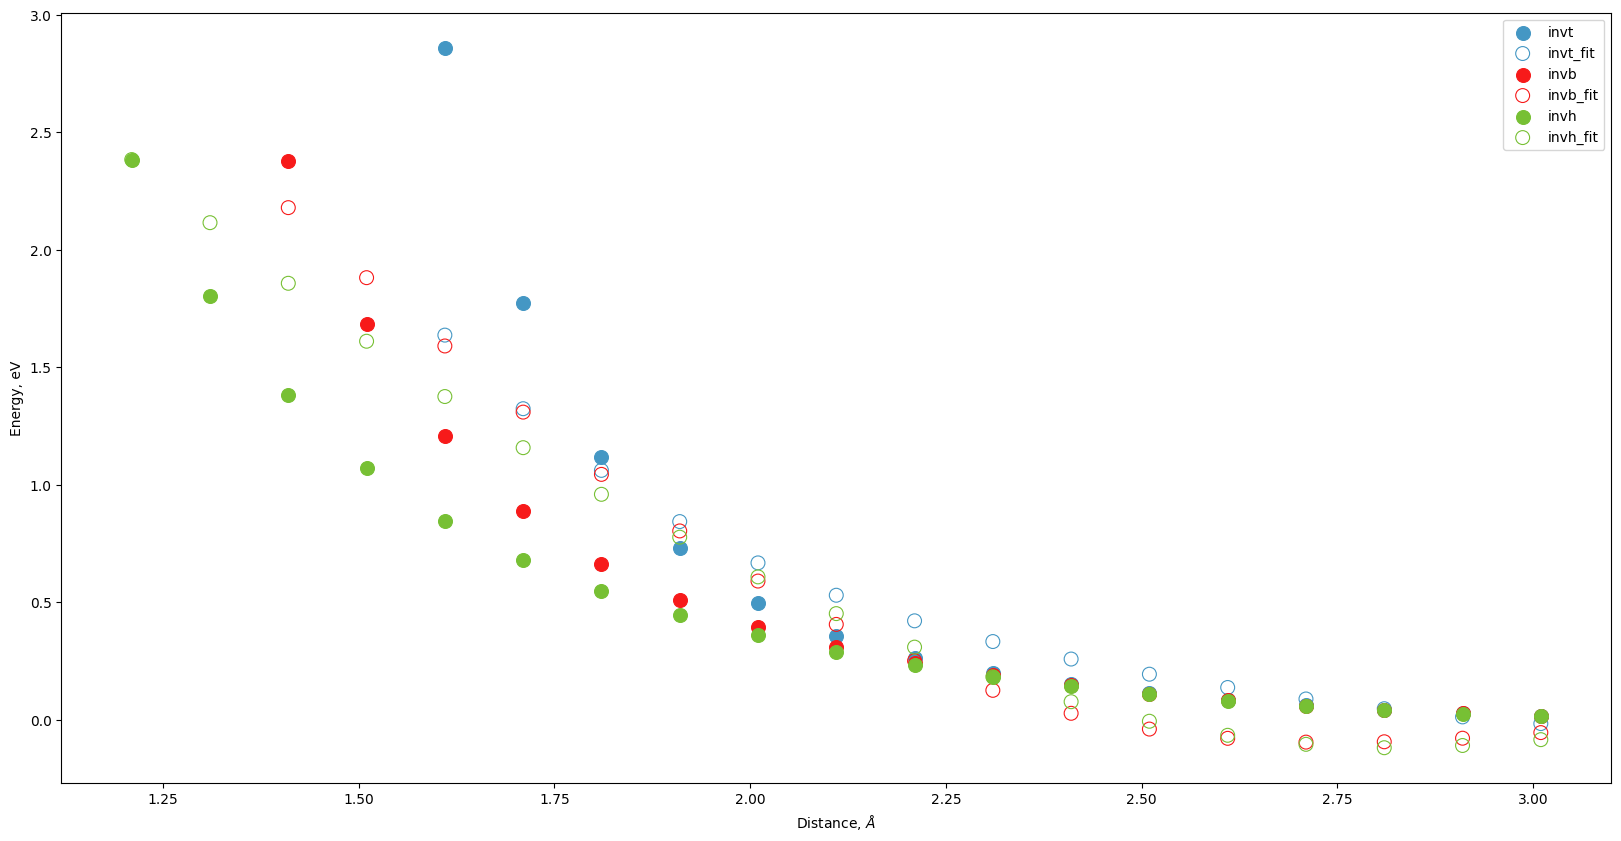

In [51]:
_categories = ['invt', 'invb', 'invh']
colors = ['#4497c4', '#f71a1a', '#77c034']
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
i=0
for pos in _categories:
    XX = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Distance']
    YY = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['DFT']
    sns.scatterplot(x=XX,  y=YY, label=pos, edgecolor=colors[i], facecolor=colors[i], s=100)
    pd.concat([XX,YY], axis=1).to_csv(f'inv_{pos}_dft.csv')
    
    XX = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Distance']
    YY = df.loc[(df['Surface'] == '100') & (df['Type'] == pos)]['Fit']
    sns.scatterplot(x=XX,  y=YY, label=pos+'_fit', edgecolor=colors[i], facecolor='none', s=100)
    pd.concat([XX,YY], axis=1).to_csv(f'inv_{pos}_padeexp.csv')
    
    i+=1
    
ax.legend()
ax.set_xlabel(r'Distance, $\AA$')
ax.set_ylabel('Energy, eV')

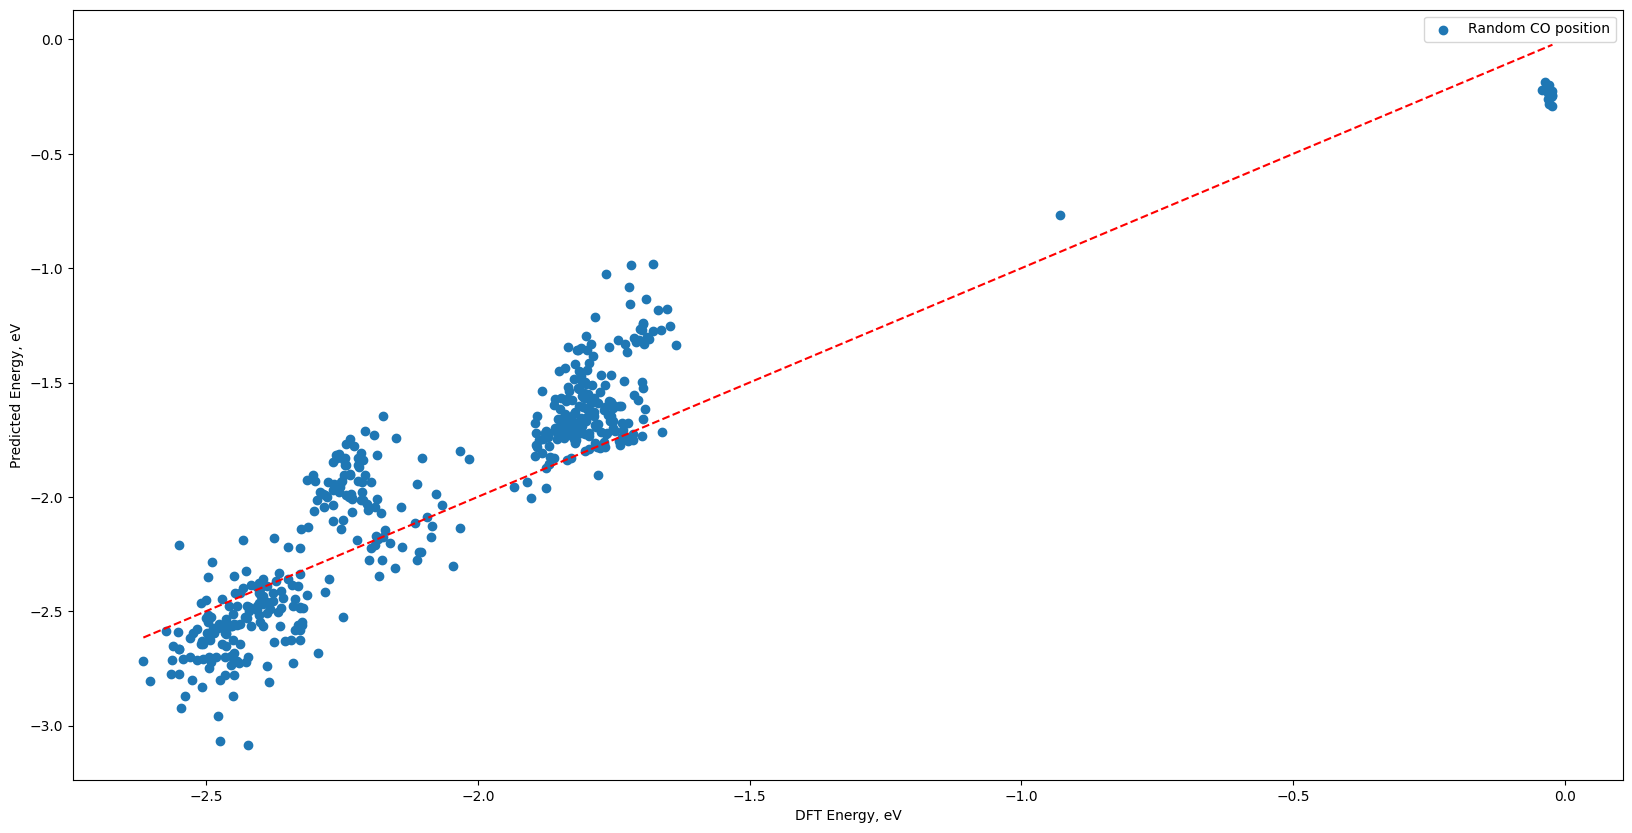

In [42]:
minval = min(df.loc[df['Surface'].isna()]['DFT'])
maxval = max(df.loc[df['Surface'].isna()]['DFT'])

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.scatter(df.loc[df['Surface'].isna()]['DFT'],  df.loc[df['Surface'].isna()]['Fit'], label = 'Random CO position')
ax.plot([minval, maxval],[minval, maxval], linestyle='--', c='r')

ax.set_xlabel('DFT Energy, eV')
ax.set_ylabel('Predicted Energy, eV')
ax.legend()

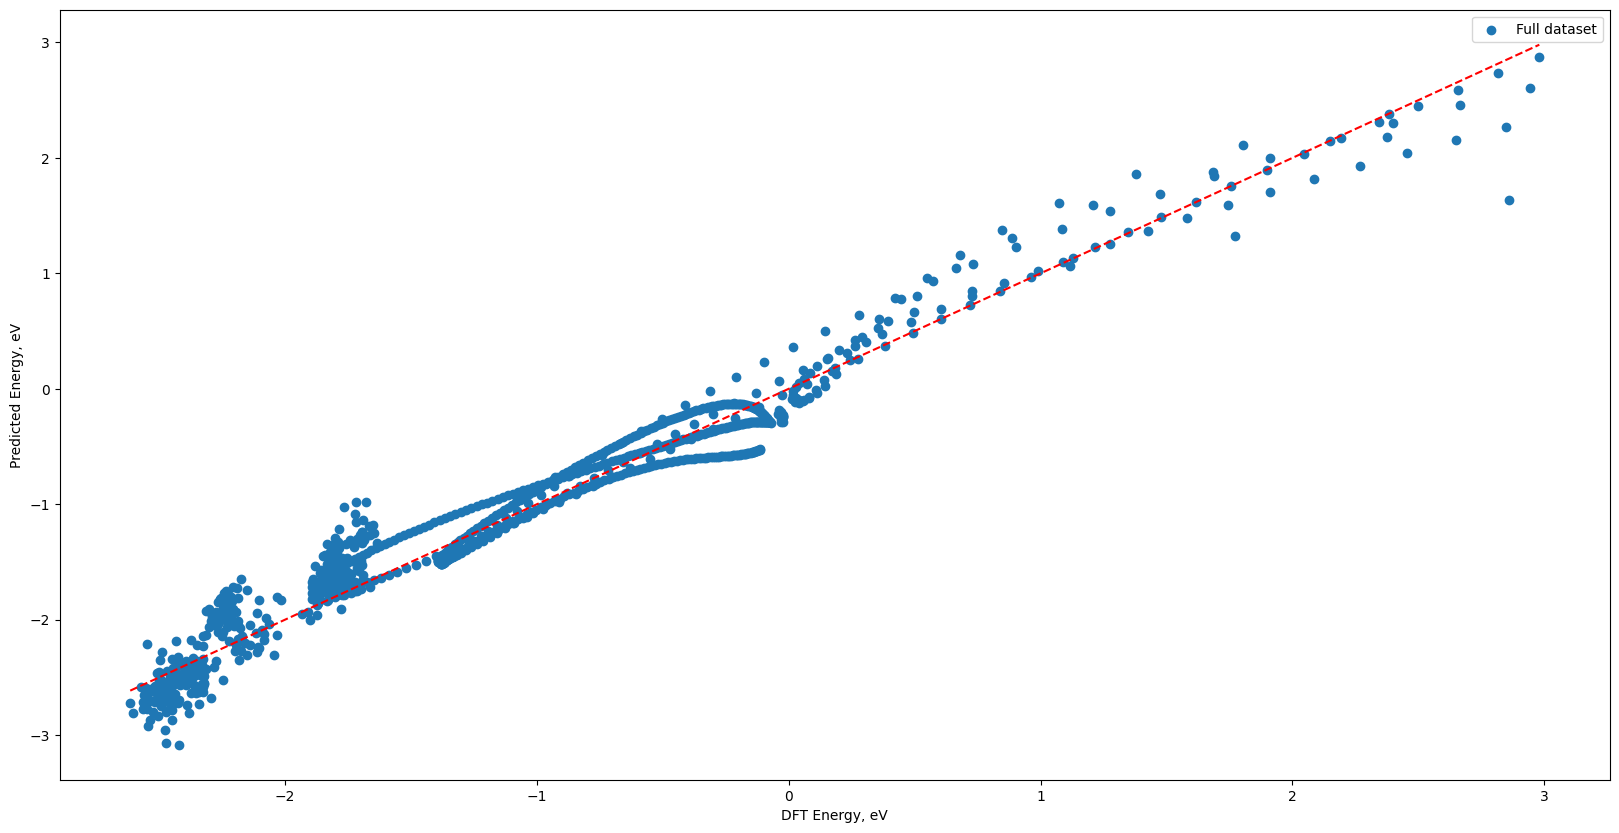

In [43]:
minval = min(df['DFT'])
maxval = max(df['DFT'])

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.scatter(df['DFT'],  df['Fit'], label = 'Full dataset')
ax.plot([minval, maxval],[minval, maxval], linestyle='--', c='r')

ax.set_xlabel('DFT Energy, eV')
ax.set_ylabel('Predicted Energy, eV')
ax.legend()